# Self made SVD

In [6]:
import helpers
import pandas as pd
import numpy as np
import scipy.sparse as sparse
from collections import defaultdict
from itertools import chain
import random

train_read=pd.read_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None)
test_read=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)
train_ui, test_ui, user_code_id, user_id_code, item_code_id, item_id_code = helpers.data_to_csr(train_read, test_read)

In [7]:
# Done similarly to https://github.com/albertauyeung/matrix-factorization-in-python
from tqdm import tqdm

class SVD():
    
    def __init__(self, train_ui, learning_rate, regularization, nb_factors, iterations):
        self.train_ui=train_ui
        self.uir=list(zip(*[train_ui.nonzero()[0],train_ui.nonzero()[1], train_ui.data]))
        
        self.learning_rate=learning_rate
        self.regularization=regularization
        self.iterations=iterations
        self.nb_users, self.nb_items=train_ui.shape
        self.nb_ratings=train_ui.nnz
        self.nb_factors=nb_factors
        
        self.Pu=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_users, self.nb_factors))
        self.Qi=np.random.normal(loc=0, scale=1./self.nb_factors, size=(self.nb_items, self.nb_factors))

    def train(self, test_ui=None):
        if test_ui!=None:
            self.test_uir=list(zip(*[test_ui.nonzero()[0],test_ui.nonzero()[1], test_ui.data]))
            
        self.learning_process=[]
        pbar = tqdm(range(self.iterations))
        for i in pbar:
            pbar.set_description(f'Epoch {i} RMSE: {self.learning_process[-1][1] if i>0 else 0}. Training epoch {i+1}...')
            np.random.shuffle(self.uir)
            self.sgd(self.uir)
            if test_ui==None:
                self.learning_process.append([i+1, self.RMSE_total(self.uir)])
            else:
                self.learning_process.append([i+1, self.RMSE_total(self.uir), self.RMSE_total(self.test_uir)])
    
    def sgd(self, uir):
        
        for u, i, score in uir:
            # Computer prediction and error
            prediction = self.get_rating(u,i)
            e = (score - prediction)
            
            # Update user and item latent feature matrices
            Pu_update=self.learning_rate * (e * self.Qi[i] - self.regularization * self.Pu[u])
            Qi_update=self.learning_rate * (e * self.Pu[u] - self.regularization * self.Qi[i])
            
            self.Pu[u] += Pu_update
            self.Qi[i] += Qi_update
        
    def get_rating(self, u, i):
        prediction = self.Pu[u].dot(self.Qi[i].T)
        return prediction
    
    def RMSE_total(self, uir):
        RMSE=0
        for u,i, score in uir:
            prediction = self.get_rating(u,i)
            RMSE+=(score - prediction)**2
        return np.sqrt(RMSE/len(uir))
    
    def estimations(self):
        self.estimations=\
        np.dot(self.Pu,self.Qi.T)

    def recommend(self, user_code_id, item_code_id, topK=10):
        
        top_k = defaultdict(list)
        for nb_user, user in enumerate(self.estimations):
            
            user_rated=self.train_ui.indices[self.train_ui.indptr[nb_user]:self.train_ui.indptr[nb_user+1]]
            for item, score in enumerate(user):
                if item not in user_rated and not np.isnan(score):
                    top_k[user_code_id[nb_user]].append((item_code_id[item], score))
        result=[]
        # Let's choose k best items in the format: (user, item1, score1, item2, score2, ...)
        for uid, item_scores in top_k.items():
            item_scores.sort(key=lambda x: x[1], reverse=True)
            result.append([uid]+list(chain(*item_scores[:topK])))
        return result
    
    def estimate(self, user_code_id, item_code_id, test_ui):
        result=[]
        for user, item in zip(*test_ui.nonzero()):
            result.append([user_code_id[user], item_code_id[item], 
                           self.estimations[user,item] if not np.isnan(self.estimations[user,item]) else 1])
        return result

In [8]:
model=SVD(train_ui, learning_rate=0.005, regularization=0.02, nb_factors=100, iterations=40)
model.train(test_ui)

Epoch 39 RMSE: 0.7481223595239049. Training epoch 40...: 100%|██████████| 40/40 [02:09<00:00,  3.25s/it]


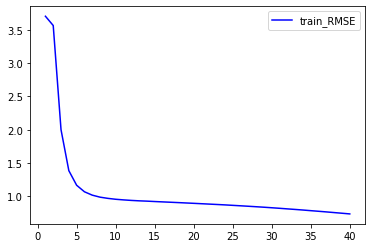

In [9]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process).iloc[:,:2]
df.columns=['epoch', 'train_RMSE']
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.legend()

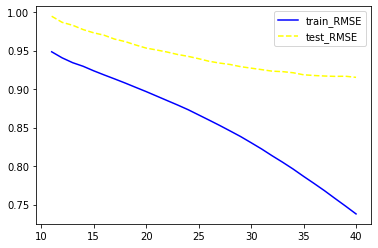

In [10]:
import matplotlib.pyplot as plt

df=pd.DataFrame(model.learning_process[10:], columns=['epoch', 'train_RMSE', 'test_RMSE'])
plt.plot('epoch', 'train_RMSE', data=df, color='blue')
plt.plot('epoch', 'test_RMSE', data=df, color='yellow', linestyle='dashed')
plt.legend()

#### Saving and evaluating recommendations

In [11]:
model.estimations()

top_n=pd.DataFrame(model.recommend(user_code_id, item_code_id, topK=10))

top_n.to_csv('Recommendations generated/ml-100k/Self_SVD_reco.csv', index=False, header=False)

estimations=pd.DataFrame(model.estimate(user_code_id, item_code_id, test_ui))
estimations.to_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', index=False, header=False)

In [12]:
import evaluation_measures as ev

estimations_df=pd.read_csv('Recommendations generated/ml-100k/Self_SVD_estimations.csv', header=None)
reco=np.loadtxt('Recommendations generated/ml-100k/Self_SVD_reco.csv', delimiter=',')

ev.evaluate(test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None),
            estimations_df=estimations_df, 
            reco=reco,
            super_reactions=[4,5])

943it [00:00, 4506.01it/s]


RMSE       MAE  precision    recall       F_1      F_05  \
0  0.915304  0.719016   0.100848  0.042228  0.051191  0.067885   

   precision_super  recall_super      NDCG       mAP       MRR      LAUC  \
0         0.092275       0.07073  0.104366  0.049606  0.192999  0.517831   

         HR  Reco in test  Test coverage   Shannon      Gini  
0  0.465536      0.867869       0.150072  3.847796  0.972676

In [13]:
import evaluation_measures as ev

dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 4962.65it/s]
943it [00:00, 4020.02it/s]
943it [00:00, 3974.62it/s]
943it [00:00, 4763.58it/s]
943it [00:00, 4203.99it/s]
943it [00:00, 4230.96it/s]
943it [00:00, 3909.05it/s]
943it [00:00, 4215.47it/s]
943it [00:00, 4293.30it/s]
943it [00:00, 4389.83it/s]
943it [00:00, 4410.76it/s]


Model        RMSE         MAE  precision    recall  \
0   Ready_LightFMpureMF    7.953192    7.462008   0.334464  0.219997   
0         Ready_LightFM  162.707436  160.855483   0.340827  0.217682   
0               Self_P3    3.702446    3.527273   0.282185  0.192092   
0     Ready_ImplicitALS    3.266101    3.065824   0.255037  0.188653   
0           Self_TopPop    2.508258    2.217909   0.188865  0.116919   
0  Ready_LightFMcontent  182.471340  180.405210   0.160339  0.101224   
0              Self_SVD    0.915304    0.719016   0.100848  0.042228   
0        Ready_Baseline    0.949459    0.752487   0.091410  0.037652   
0        Self_GlobalAvg    1.125760    0.943534   0.061188  0.025968   
0          Ready_Random    1.514355    1.216383   0.049735  0.022300   
0       Self_BaselineUI    0.967585    0.762740   0.000954  0.000170   

        F_1      F_05  precision_super  recall_super      NDCG       mAP  \
0  0.217225  0.254981         0.233798      0.266952  0.398778  0.263058   
0  0.217990  0.258010         0.243884      0.260663  0.403850  0.268266   
0  0.186749  0.216980         0.204185      0.240096  0.339114  0.204905   
0  0.176852  0.201189         0.166631      0.214925  0.305908  0.172546   
0  0.118732  0.141584         0.130472      0.137473  0.214651  0.111707   
0  0.102198  0.121074         0.102682      0.112455  0.180079  0.087429   
0  0.051191  0.067885         0.092275      0.070730  0.104366  0.049606   
0  0.046030  0.061286         0.079614      0.056463  0.095957  0.043178   
0  0.031383  0.041343         0.040558      0.032107  0.067695  0.027470   
0  0.025782  0.033598         0.028219      0.021751  0.054383  0.021119   
0  0.000278  0.000463         0.000644      0.000189  0.000752  0.000168   

        MRR      LAUC        HR  Reco in test  Test coverage   Shannon  \
0  0.629129  0.607709  0.913043      1.000000       0.275613  5.085818   
0  0.637590  0.606568  0.898197      1.000000       0.351371  5.366291   
0  0.572157  0.593544  0.875928      1.000000       0.077201  3.875892   
0  0.523871  0.591709  0.889714      1.000000       0.502886  5.722957   
0  0.400939  0.555546  0.765642      1.000000       0.038961  3.159079   
0  0.337825  0.547572  0.704136      0.974973       0.264791  4.909893   
0  0.192999  0.517831  0.465536      0.867869       0.150072  3.847796   
0  0.198193  0.515501  0.437964      1.000000       0.033911  2.836513   
0  0.171187  0.509546  0.384942      1.000000       0.025974  2.711772   
0  0.133978  0.507680  0.339343      0.986957       0.177489  5.088670   
0  0.001677  0.496424  0.009544      0.600530       0.005051  1.803126   

       Gini  
0  0.913665  
0  0.885046  
0  0.974947  
0  0.827507  
0  0.987317  
0  0.926201  
0  0.972676  
0  0.991139  
0  0.992003  
0  0.907676  
0  0.996380

### Embeddings

In [14]:
x=np.array([[1,2],[3,4]])
display(x)
x/np.linalg.norm(x, axis=1)[:,None]

array([[1, 2],
       [3, 4]])

array([[0.4472136 , 0.89442719],
       [0.6       , 0.8       ]])

In [15]:
item=random.choice(list(set(train_ui.indices)))

embeddings_norm=model.Qi/np.linalg.norm(model.Qi, axis=1)[:,None] # we do not mean-center here
# omitting normalization also makes sense, but items with a greater magnitude will be recommended more often

similarity_scores=np.dot(embeddings_norm,embeddings_norm[item].T)
top_similar_items=pd.DataFrame(enumerate(similarity_scores), columns=['code', 'score'])\
.sort_values(by=['score'], ascending=[False])[:10]

top_similar_items['item_id']=top_similar_items['code'].apply(lambda x: item_code_id[x])

items=pd.read_csv('./Datasets/ml-100k/movies.csv')

result=pd.merge(top_similar_items, items, left_on='item_id', right_on='id')

result

code     score  item_id    id  \
0    44  1.000000       45    45   
1   855  0.966812      856   856   
2  1403  0.966571     1404  1404   
3   112  0.966115      113   113   
4   955  0.965365      956   956   
5  1222  0.965232     1223  1223   
6    60  0.964481       61    61   
7   535  0.963322      536   536   
8  1102  0.962597     1103  1103   
9   713  0.962459      714   714   

                                               title          genres  
0                         Eat Drink Man Woman (1994)   Comedy, Drama  
1                              Night on Earth (1991)   Comedy, Drama  
2                              Withnail and I (1987)          Comedy  
3  Horseman on the Roof, The (Hussard sur le toit...           Drama  
4                               Nobody's Fool (1994)           Drama  
5                            King of the Hill (1993)           Drama  
6                         Three Colors: White (1994)           Drama  
7                                     Ponette (1996)           Drama  
8                                       Trust (1990)   Comedy, Drama  
9                                  Carrington (1995)  Drama, Romance

# project task 5:  implement SVD on top baseline (as it is in Surprise library)

In [16]:
# making changes to our implementation by considering additional parameters in the gradient descent procedure 
# seems to be the fastest option
# please save the output in 'Recommendations generated/ml-100k/Self_SVDBaseline_reco.csv' and
# 'Recommendations generated/ml-100k/Self_SVDBaseline_estimations.csv'

# Ready-made SVD - Surprise implementation

### SVD

In [17]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD(biased=False) # to use unbiased version

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVD_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVD_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


### SVD biased - on top baseline

In [18]:
import helpers
import surprise as sp
import imp
imp.reload(helpers)

algo = sp.SVD() # default is biased=True

helpers.ready_made(algo, reco_path='Recommendations generated/ml-100k/Ready_SVDBiased_reco.csv',
          estimations_path='Recommendations generated/ml-100k/Ready_SVDBiased_estimations.csv')

Generating predictions...
Generating top N recommendations...
Generating predictions...


In [19]:
import imp
imp.reload(ev)

import evaluation_measures as ev
dir_path="Recommendations generated/ml-100k/"
super_reactions=[4,5]
test=pd.read_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None)

ev.evaluate_all(test, dir_path, super_reactions)

943it [00:00, 4110.82it/s]
943it [00:00, 4014.43it/s]
943it [00:00, 3946.85it/s]
943it [00:00, 4832.12it/s]
943it [00:00, 4090.40it/s]
943it [00:00, 4152.16it/s]
943it [00:00, 4456.22it/s]
943it [00:00, 3943.66it/s]
943it [00:00, 4298.65it/s]
943it [00:00, 4243.05it/s]
943it [00:00, 4391.40it/s]
943it [00:00, 4528.23it/s]
943it [00:00, 4419.43it/s]


Model        RMSE         MAE  precision    recall  \
0   Ready_LightFMpureMF    7.953192    7.462008   0.334464  0.219997   
0         Ready_LightFM  162.707436  160.855483   0.340827  0.217682   
0               Self_P3    3.702446    3.527273   0.282185  0.192092   
0     Ready_ImplicitALS    3.266101    3.065824   0.255037  0.188653   
0           Self_TopPop    2.508258    2.217909   0.188865  0.116919   
0  Ready_LightFMcontent  182.471340  180.405210   0.160339  0.101224   
0             Ready_SVD    0.951475    0.750225   0.099470  0.051407   
0              Self_SVD    0.915304    0.719016   0.100848  0.042228   
0        Ready_Baseline    0.949459    0.752487   0.091410  0.037652   
0       Ready_SVDBiased    0.937841    0.739906   0.079427  0.032570   
0        Self_GlobalAvg    1.125760    0.943534   0.061188  0.025968   
0          Ready_Random    1.514355    1.216383   0.049735  0.022300   
0       Self_BaselineUI    0.967585    0.762740   0.000954  0.000170   

        F_1      F_05  precision_super  recall_super      NDCG       mAP  \
0  0.217225  0.254981         0.233798      0.266952  0.398778  0.263058   
0  0.217990  0.258010         0.243884      0.260663  0.403850  0.268266   
0  0.186749  0.216980         0.204185      0.240096  0.339114  0.204905   
0  0.176852  0.201189         0.166631      0.214925  0.305908  0.172546   
0  0.118732  0.141584         0.130472      0.137473  0.214651  0.111707   
0  0.102198  0.121074         0.102682      0.112455  0.180079  0.087429   
0  0.056004  0.070229         0.088197      0.083166  0.115422  0.053515   
0  0.051191  0.067885         0.092275      0.070730  0.104366  0.049606   
0  0.046030  0.061286         0.079614      0.056463  0.095957  0.043178   
0  0.039804  0.053022         0.071030      0.050639  0.088490  0.039308   
0  0.031383  0.041343         0.040558      0.032107  0.067695  0.027470   
0  0.025782  0.033598         0.028219      0.021751  0.054383  0.021119   
0  0.000278  0.000463         0.000644      0.000189  0.000752  0.000168   

        MRR      LAUC        HR  Reco in test  Test coverage   Shannon  \
0  0.629129  0.607709  0.913043      1.000000       0.275613  5.085818   
0  0.637590  0.606568  0.898197      1.000000       0.351371  5.366291   
0  0.572157  0.593544  0.875928      1.000000       0.077201  3.875892   
0  0.523871  0.591709  0.889714      1.000000       0.502886  5.722957   
0  0.400939  0.555546  0.765642      1.000000       0.038961  3.159079   
0  0.337825  0.547572  0.704136      0.974973       0.264791  4.909893   
0  0.253329  0.522434  0.522800      0.996713       0.216450  4.424505   
0  0.192999  0.517831  0.465536      0.867869       0.150072  3.847796   
0  0.198193  0.515501  0.437964      1.000000       0.033911  2.836513   
0  0.201565  0.512929  0.425239      0.997031       0.170996  4.167051   
0  0.171187  0.509546  0.384942      1.000000       0.025974  2.711772   
0  0.133978  0.507680  0.339343      0.986957       0.177489  5.088670   
0  0.001677  0.496424  0.009544      0.600530       0.005051  1.803126   

       Gini  
0  0.913665  
0  0.885046  
0  0.974947  
0  0.827507  
0  0.987317  
0  0.926201  
0  0.952962  
0  0.972676  
0  0.991139  
0  0.963929  
0  0.992003  
0  0.907676  
0  0.996380